In [1]:
# Import stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
# # Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# # ms-python.python added
# import os
# try:
# 	# os.chdir(os.path.join(os.getcwd(), '..'))
#     os.chdir(os.path.join(os.getcwd(), "./scripts-notebooks"))
#     print(os.getcwd())
# except Exception as e:
# 	print(e)

/Users/SamYang95/GRN_Inference_IY/scripts-notebooks


In [3]:
# Get expression data
ko_df = pd.read_csv('../dataset/yeast_networks/expression/KO.txt', sep='\t').set_index('Gene')
nv_df = pd.read_csv('../dataset/yeast_networks/expression/NatVar.txt', sep='\t').set_index('Gene')
stress_df = pd.read_csv('../dataset/yeast_networks/expression/Stress.txt', sep='\t').set_index('Name')

# Get Transcription Factors
ko_tf = pd.read_csv('../dataset/yeast_networks/expression/KO_TF_names.txt', sep='\t', header=None)
ko_tf.columns = ['TF']

nv_tf = pd.read_csv('../dataset/yeast_networks/expression/NatVar_TF_names.txt', sep='\t', header=None)
nv_tf.columns = ['TF']

stress_tf = pd.read_csv('../dataset/yeast_networks/expression/Stress_TF_names.txt', sep='\t', header=None)
stress_tf.columns = ['TF']

In [4]:
df = ko_df.merge(nv_df, how='inner', left_index=True, right_index=True)
df = df.merge(stress_df, how='inner', left_index=True, right_index=True)

tf = ko_tf.merge(nv_tf, how='inner', left_on='TF', right_on='TF')
tf = tf.merge(stress_tf, how='inner', left_on='TF', right_on='TF')

In [5]:
ko_gold_df = pd.read_csv("../dataset/yeast_networks/gold/MacIsaac2.KO.txt", sep = '\t', header = None, names = ['Regulator', 'Target'])
nv_gold_df = pd.read_csv("../dataset/yeast_networks/gold/MacIsaac2.NatVar.txt", sep = '\t', header = None, names = ['Regulator', 'Target'])
stress_gold_df = pd.read_csv("../dataset/yeast_networks/gold/MacIsaac2.Stress.txt", sep = '\t', header = None, names = ['Regulator', 'Target'])

gold_df = ko_gold_df.merge(nv_gold_df, how='outer', left_on=['Regulator', 'Target'], right_on=['Regulator', 'Target'])
gold_df = gold_df.merge(stress_gold_df, how='outer', left_on=['Regulator', 'Target'], right_on=['Regulator', 'Target'])

In [6]:
# Prepare dataset: set which are the predictors (TF), and which are the targets
from sklearn import model_selection
def prep_dataset(target_gene, tf_list, exp_df):
    '''
    Prepares training set and test set for target gene
    
    Args:
        - target_gene: target gene for the iteration (y)
        - exp_df: expression dataframe (already in pandas df format)
        - tf_list: transcription factors, which will be the predictors (X)
        
    Returns:
        - Training and Testing set to be used in model predictions
        - label for predictors, so we can subset this later
    '''
    # Get y (target) and predictor matrix (X)
    y = exp_df.loc[target_gene, :].values
    X = exp_df.loc[tf_list, :]
    
    if target_gene in tf_list.values:
        X = X.drop(index=target_gene)
    
    X_label = X.index # Predictor labels for X
    X = X.values.transpose()
    
    # Split 80:20 for test and train
    # X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2)

    
    return X, y, X_label
    # return X_train, X_test, y_train, y_test, X_label

In [7]:
# Performance Metrics
def iou_score(gold_df, pred_grn_edges, target_list=None):
    '''
    Function to score predicted grn vs gold standard based on intersection over union.

    Score:
    For starters, we will use the simple score of intersection / union
    Intersection: Count of edges in both gold standard AND predicted grn
    Union: Count of gold standard edges + predicted grn edges - Intersection

    Intersection / Union is the score.

    Args:
        - gold_file: Path to gold standard file
        - pred_grn_edges: set of predicted grn edges

    Returns:
        - IOU score
    '''

    # Set of gold standard edges
    if target_list is not None:
        gold_df = gold_df[gold_df['Target'].isin(target_list)]

    gold_edge_set = set(gold_df.loc[:, 'Regulator'] + '->' + gold_df.loc[:, 'Target'])
    gold_regulators = set(gold_df.loc[:, 'Regulator'])
    pred_grn_edges = [edge for edge in pred_grn_edges if edge.split('->')[0] in gold_regulators]

    # Get Intersection and Union
    intersection = gold_edge_set.intersection(pred_grn_edges)
    union = gold_edge_set.union(pred_grn_edges)

    # Get score: Intersection / Union
    iou_score = len(intersection) / len(union)
    print(f'Union edges count: {len(union)}')
    print(f'Intersection edges count: {len(intersection)}')

    print(f'Gold edges count: {len(gold_edge_set)}')
    print(f'Pred edges count: {len(pred_grn_edges)}')
        
    return iou_score

In [8]:
import time

In [9]:
gold_tfs = set(gold_df['Regulator'])

# Experiments

In [208]:
pd.DataFrame(index=target_list, columns=gold_tfs).loc['YDR404C']['YKL062W', 'YPR065W'] = [1,2]
# plt.scatter(x=list(gold_tfs), y=pd.DataFrame(index=target_list, columns=gold_tfs).loc['YBL004W'])

In [10]:
# Only train on a subset of the target genes to speed up the tuning process
num_target_genes = 30
indices = np.random.randint(df.shape[0], size=num_target_genes)
indices = [True if i in indices else False for i in range(df.shape[0])]
target_list = df.loc[indices].index.values

tf_list = tf.loc[:, 'TF']

## Experiment On RandomForestRegressor

In [11]:
regforest_edges = set()
regforest_train_scores = []
regforest_feature_importances = pd.DataFrame(index=target_list, columns=tf_list)
regforest_time = []

# for target in exp_df.index.values:
for target in target_list:    
    # Prep data
    X_train, y_train, X_label = prep_dataset(target, tf_list, df)

    # Use regerssion tree
    start = time.time()
    forest_reg = RandomForestRegressor(n_estimators = 30, max_depth = 30, bootstrap = True, min_samples_leaf = 10, n_jobs=-1)
    forest_reg.fit(X_train, y_train)
    regforest_time.append(time.time() - start)

    # Get Scores (R^2)
    train_score = forest_reg.score(X_train, y_train)
    regforest_train_scores.append(train_score)
    
    # Get feature importance
    predictors = X_label
    nonzero_filter = forest_reg.feature_importances_ != 0
    nonzero_preds = predictors[nonzero_filter]
    regforest_feature_importances.loc[target][X_label] = forest_reg.feature_importances_

    # Add the predicted regulators -> target edge to the predicted edges
    for reg in nonzero_preds.values:
        regforest_edges.add(f'{reg}->{target}')

In [12]:
regforest_score = iou_score(gold_df, regforest_edges)
print("===========================")
print(f'regforest train scores average: {np.array(regforest_train_scores).mean()}')
print(f'regforest score: {regforest_score}')

Union edges count: 6716
Intersection edges count: 20
Gold edges count: 3843
Pred edges count: 2893
regforest train scores average: 0.791551621581661
regforest score: 0.0029779630732578916


In [131]:
from sklearn.metrics import roc_curve, auc

def plot_roc(gold_df, feature_importances, target_list = None):

    # only evaluate on target_list
    if target_list is not None:
        gold_df = gold_df[gold_df['Target'].isin(target_list)]

    # only evaluate on tfs that are in the gold_df
    gold_regulators = set(gold_df.loc[:, 'Regulator'])

    feature_importances = feature_importances.loc[target_list][gold_regulators]
    y_true = pd.DataFrame(0, index=feature_importances.index, columns=feature_importances.columns)
    
    for _, edge in gold_df.iterrows():
        y_true.loc[edge.Target][edge.Regulator] = 1

    feature_importances = feature_importances.values.flatten()
    y_true = y_true.values.flatten()
    
    fpr, tpr, thresholds = roc_curve(y_true, feature_importances)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc})')
    plt.plot([0,1], [0,1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc='lower right')
    plt.show()
    # iou_score = len(intersection) / len(union)

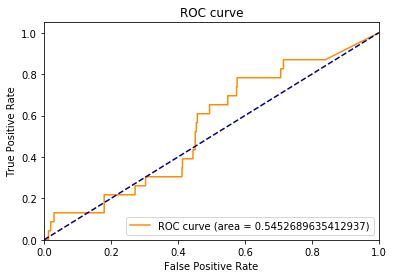

In [132]:
plot_roc(gold_df, regforest_feature_importances, target_list)

In [39]:
def plot_feature_importance(target, feature_importances, gold_df, labels):    
    gold = gold_df[gold_df['Target'] == target]['Regulator'].values
    gold_filter = labels.isin(gold)
    
    if len(gold) == 0:
        print("no incoming edges to the target")
        return

    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ax.scatter(x=labels[~gold_filter], y=feature_importances[~gold_filter], s=2)
    ax.scatter(x=labels[gold_filter], y=feature_importances[gold_filter], s=20, c='red', marker='^')
    ax.set_title(f"Target: {target}")
    ax.xaxis.set_visible(False)

    # Compute ranking of the features
    feature_importances_rank = np.empty_like(feature_importances)
    feature_importances_rank[np.argsort(feature_importances)] = np.arange(len(feature_importances), 0, step=-1)

    print("=========Feature importance=========")
    for tf, feature_importance, rank in zip(labels[gold_filter], feature_importances[gold_filter], feature_importances_rank[gold_filter]):
        print(f'{tf}: {feature_importance}, rank: {rank}')

Found a target with incoming edge(s): YBR159W
=========Feature importance=========
YLR131C: 0.0004271904363104632, rank: 223
YER161C: 0.0004158773524099796, rank: 228


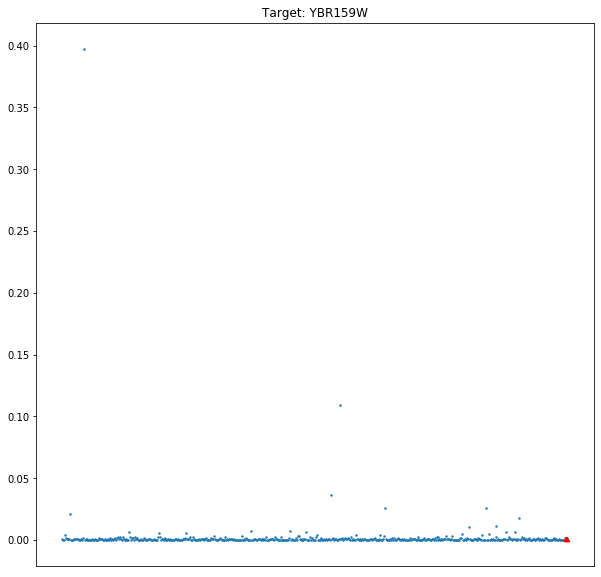

In [45]:
examine_target_idx, examine_target = None, None
while True:
    examine_target_idx = np.random.randint(len(target_list))
    examine_target = target_list[examine_target_idx]
    if len(gold_df[gold_df['Target'] == examine_target]['Regulator'].values) > 0:
        print(f'Found a target with incoming edge(s): {examine_target}')
        break

examine_feature_imp = np.array(regforest_feature_importances.loc[examine_target])
# labels = df.loc[tf_list, :].drop(index=examine_target).index if examine_target in tf_list.values else df.loc[tf_list, :].index
plot_feature_importance(examine_target, examine_feature_imp, gold_df, tf_list)

## Experiment On Lasso

In [ ]:
pred_edges = set()
tf_list = tf.loc[:, 'TF']

train_scores = []
feature_importances = []

# for target in exp_df.index.values:
for target in target_list:    
    # Prep data
    X_train, y_train, X_label = prep_dataset(target, tf_list, df)

    # Use regerssion tree
    forest_reg = RandomForestRegressor(n_estimators = 30, max_depth = 15, bootstrap = True, min_samples_leaf = 10, n_jobs=-1)
    forest_reg.fit(X_train, y_train)

    # Get Scores (R^2)
    train_score = forest_reg.score(X_train, y_train)
    train_scores.append(train_score)
    
    # Get feature importance
    predictors = X_label
    nonzero_filter = forest_reg.feature_importances_ != 0
    nonzero_preds = predictors[nonzero_filter]
    feature_importances.append(feature_importances)
    
    # Add the predicted regulators -> target edge to the predicted edges
    for reg in nonzero_preds.values:
        pred_edges.add(f'{reg}->{target}')

In [30]:
np.array(regforest_feature_importances.loc[examine_target]).shape
tf_list.shape

(532,)